<a href="https://colab.research.google.com/github/sottohy/Sperm-Embryo-classification-models/blob/main/pretrained_embryo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd/content/drive/MyDrive/Grad/Embryo dataset

/content/drive/.shortcut-targets-by-id/18pb5M1h6O5n0W1bJwpaWsjZhcV0KQsE8/Embryo dataset


In [ ]:
# necessary libraries

import os
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
!pip install utils
from utils import *
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from itertools import chain
from datetime import datetime
import statistics
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC, BinaryCrossentropy, FalseNegatives, FalsePositives
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201, VGG16, ResNet50
from keras import backend as K
from tensorflow.keras import Sequential
import keras
import matplotlib
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=e5f5d2fca16a09ebb4b236262b2304366ffcbbd7f6759bd16f059edade1e2698
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [ ]:
path, dirs, files = next(os.walk("train-test/train/bad"))
# path is the actual path, dirs has the name of the folder, and files has the images
file_count = len(files) # returns how many images
print('Bad:', file_count)

path, dirs, files = next(os.walk("train-test/train/good"))
# path is the actual path, dirs has the name of the folder, and files has the images
file_count = len(files) # returns how many images
print('Good:', file_count)

Bad: 890
Good: 1240


In [ ]:
image_size = (224, 224) # the model requires this
batch_size = 32

train_df = tf.keras.preprocessing.image_dataset_from_directory(
    "train-test/train",
    validation_split = 0.20, # split 20%
    subset = "training", # this means that this subset that we're talking is for training (80%)
    seed = 1337, # so the splitting isn't random each time
    image_size = image_size,
    batch_size = batch_size,
)

val_df = tf.keras.preprocessing.image_dataset_from_directory(
    "train-test/train",
    validation_split = 0.20, # split 20%
    subset = "validation", # this means that this subset that we're talking is for validation (20%)
    seed = 1337, # so the splitting isn't random each time
    image_size = image_size,
    batch_size = batch_size,
)

test_df = tf.keras.preprocessing.image_dataset_from_directory(
    "train-test/test",
    image_size = image_size,
    batch_size = batch_size,
    shuffle = False, # really important for testing
)

# the output means: 1704 training, 426 validation, 534 testing

Found 2130 files belonging to 2 classes.
Using 1704 files for training.
Found 2130 files belonging to 2 classes.
Using 426 files for validation.
Found 534 files belonging to 2 classes.


In [ ]:
# test_df returns both X and Y
# we want this Y which we will call "y_true": y_true refers to the true labels in test
# we need to save them in a variable to compare with y_pred after testing

y_true = np.concatenate([y for x,y in test_df], axis=0)

In [ ]:
# this reduces the time spent waiting for data to be loaded

train_df = train_df.prefetch(buffer_size=32)
val_df = val_df.prefetch(buffer_size=32)

In [ ]:
# hyperparameters

IMG_IND = 224 # size
IMG_SHAPE = (IMG_IND, IMG_IND, 3)
LOSS = BinaryCrossentropy() # because this is a binary calsssifation problem
IMG_SIZE = (224, 224)
SEED = 2
BATCH_SIZE = 16

In [ ]:
# function that takes a model name and applies it (only necessary when applying multiple models)

def get_callbacks(model_name):
  os.makedirs("/content/drive/MyDrive/Grad", exist_ok=True)
  filepath = os.path.join("/content/drive/MyDrive/Grad", f'model.{model_name}.h5')

  callbacks = []
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, verbose=1, monitor='val_loss', mode='min')
  # naming the model
  callbacks.append(checkpoint)

  anne = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=2, min_lr=0.0000001, min_delta=0.00001, mode='auto')
  # if after 5 times and there is no improvement in val_loss, decrease lr by 50%
  callbacks.append(anne)

  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  # if after 10 times there is no improvement, stop
  callbacks.append(earlystop)

  return callbacks

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet101

from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization


# Define the optimizer
OPTIMIZER = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Load base model
#base_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model = ResNet101(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

# Set the base model to be trainable
base_model.trainable = False # should usually be false, that's the point of using pretrained

x = base_model.output
x = GlobalAveragePooling2D()(x)  # applying something similar to flatten to the layer before the last layer
#x = Dropout(0.5)(x)  # Adding dropout with a rate of 0.5
#x = Dense(256, activation='relu')(x)  # Adding another dense layer
#x = BatchNormalization()(x)  # Adding batch normalization
predictions = Dense(1, activation='sigmoid', name='Final')(x) # building the final layer

# Build the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])


In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
callbacks = get_callbacks('resnet101') # calling the function i made earlier

history = model.fit(train_df, epochs=20, validation_data=val_df, callbacks=[callbacks])

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_df)

Epoch 1/20
54/54 [==============================] - ETA: 0s - loss: 0.5381 - accuracy: 0.7107
Epoch 1: saving model to /content/drive/MyDrive/Grad/model.resnet101.h5
54/54 [==============================] - 25s 333ms/step - loss: 0.5381 - accuracy: 0.7107 - val_loss: 0.4143 - val_accuracy: 0.8169 - lr: 0.0010
Epoch 2/20
54/54 [==============================] - ETA: 0s - loss: 0.3652 - accuracy: 0.8374
Epoch 2: saving model to /content/drive/MyDrive/Grad/model.resnet101.h5
54/54 [==============================] - 16s 276ms/step - loss: 0.3652 - accuracy: 0.8374 - val_loss: 0.3725 - val_accuracy: 0.8146 - lr: 0.0010
Epoch 3/20
54/54 [==============================] - ETA: 0s - loss: 0.3058 - accuracy: 0.8703
Epoch 3: saving model to /content/drive/MyDrive/Grad/model.resnet101.h5
54/54 [==============================] - 19s 332ms/step - loss: 0.3058 - accuracy: 0.8703 - val_loss: 0.3847 - val_accuracy: 0.7840 - lr: 0.0010
Epoch 4/20
54/54 [==============================] - ETA: 0s - loss:

Test Accuracy: 0.9307116270065308


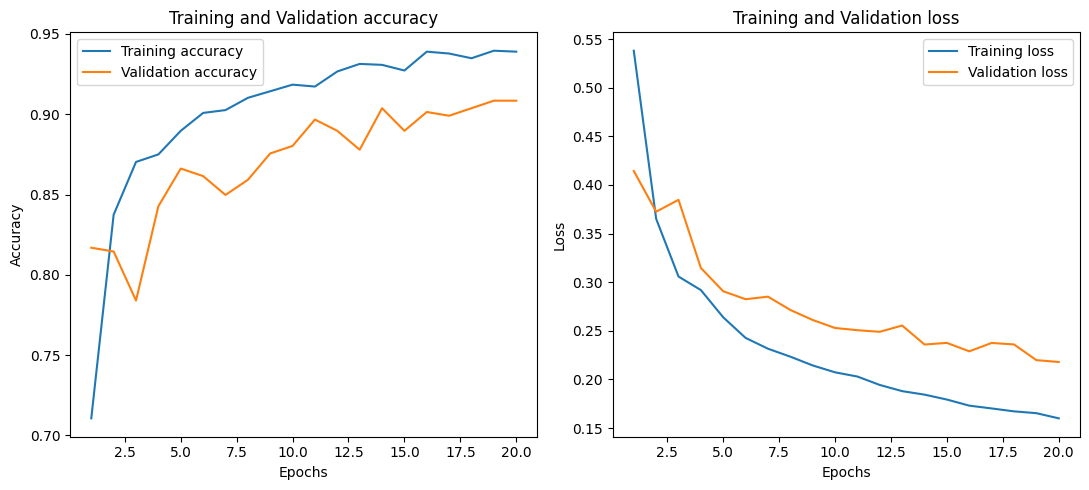

In [ ]:
# Print the test accuracy
print(f"Test Accuracy: {test_accuracy}")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

# Train and validation accuracy
ax1.plot(epochs, acc, label='Training accuracy')
ax1.plot(epochs, val_acc, label='Validation accuracy')
ax1.set_title('Training and Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Train and validation loss
ax2.plot(epochs, loss, label='Training loss')
ax2.plot(epochs, val_loss, label='Validation loss')
ax2.set_title('Training and Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()


17/17 [==============================] - 6s 186ms/step


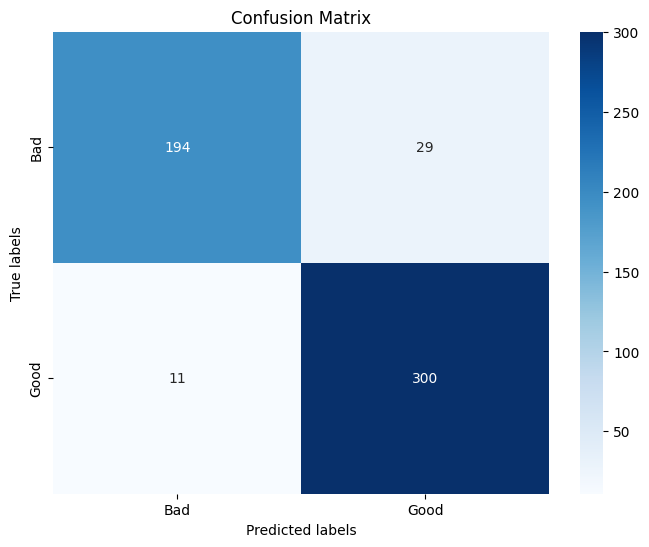

              precision    recall  f1-score   support

           0       0.95      0.87      0.91       223
           1       0.91      0.96      0.94       311

    accuracy                           0.93       534
   macro avg       0.93      0.92      0.92       534
weighted avg       0.93      0.93      0.92       534



In [ ]:

# Assuming your model is already trained and stored in the 'model' variable

# Make predictions on the test data
predictions = model.predict(test_df)
predictions_binary = np.round(predictions).flatten()

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, predictions_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(classification_report(y_true, predictions_binary))
